In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data=np.genfromtxt('perceptron_toydata.txt',delimiter='\t')
X,y=data[:,:2],data[:,2]
y=y.astype(np.int32)

print('Class label counts:', np.bincount(y))
print('X.shape:', X.shape)
print('y.shape:', y.shape)

# Shuffling & train/test split
shuffle_idx = np.arange(y.shape[0])
shuffle_rng = np.random.RandomState(123)
shuffle_rng.shuffle(shuffle_idx)
X, y = X[shuffle_idx], y[shuffle_idx]

X_train, X_test = X[shuffle_idx[:70]], X[shuffle_idx[70:]]
y_train, y_test = y[shuffle_idx[:70]], y[shuffle_idx[70:]]

# Normalize (mean zero, unit variance)
mu, sigma = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma


Class label counts: [50 50]
X.shape: (100, 2)
y.shape: (100,)


In [3]:
class Perceptron:

    def __init__(self, num_features) -> None:
        self.num_features=num_features
        self.weights=np.zeros((num_features,1),dtype=np.float32)
        self.bias=np.zeros(1,dtype=np.float32)
    
    def forward(self, x):
        linear=np.dot(x, self.weights)+self.bias
        pred=np.where(linear>=0,1,0)
        return pred
    
    def backward(self, x, y):
        y_hat=self.forward(x)
        error=y-y_hat
        return error
    
    def train(self, x, y, epochs):
        for _ in range(epochs):
            for i in range(y.shape[0]):
                errors=self.backward(x[i].reshape(1, self.num_features), y[i]).reshape(-1)
                self.weights += (errors *x[i]).reshape(self.num_features, -1)
                self.bias +=errors
    
    def evaluate( self, x, y):
        pred=self.forward(x).reshape(-1)
        accuracy= np.sum(pred==y)/y.shape[0]
        return (accuracy*100)



In [4]:
pp=Perceptron(num_features=2)

pp.train(X_train, y_train, epochs=10)

print(f"Model Parameters:\n Weigths:{pp.weights}\n Bias:{pp.bias}")

Model Parameters:
 Weigths:[[2.0293188]
 [0.5932976]]
 Bias:[-1.]


In [5]:
print(f"Train Accuracy:{pp.evaluate(X_train,y_train)}")
print(f"Test Accuracy:{pp.evaluate(X_test,y_test)}")

Train Accuracy:100.0
Test Accuracy:100.0


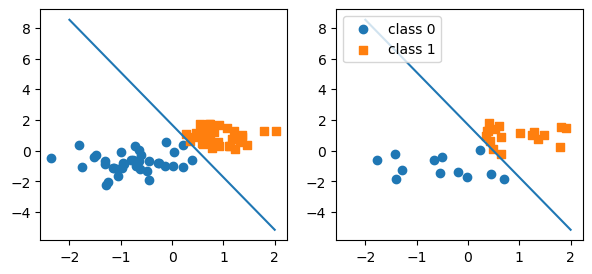

In [6]:
##########################
### 2D Decision Boundary
##########################

w, b = pp.weights, pp.bias

x0_min = -2
x1_min = ( (-(w[0] * x0_min) - b[0]) 
          / w[1] )

x0_max = 2
x1_max = ( (-(w[0] * x0_max) - b[0]) 
          / w[1] )

# x0*w0 + x1*w1 + b = 0
# x1  = (-x0*w0 - b) / w1


fig, ax = plt.subplots(1, 2, sharex=True, figsize=(7, 3))

ax[0].plot([x0_min, x0_max], [x1_min, x1_max])
ax[0].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label='class 0', marker='o')
ax[0].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='class 1', marker='s')

ax[1].plot([x0_min, x0_max], [x1_min, x1_max])
ax[1].scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], label='class 0', marker='o')
ax[1].scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], label='class 1', marker='s')

ax[1].legend(loc='upper left')
plt.show()

In [19]:
class PSOPerceptron:
    def __init__(self, num_features, swarm_size=30, learning_rate=0.5, inertia_weight=0.5, epochs=100):
        self.num_features = num_features
        self.swarm_size = swarm_size
        self.learning_rate = learning_rate
        self.inertia_weight = inertia_weight
        self.epochs = epochs
        
        self.particles = np.random.randn(swarm_size, num_features + 1)  # num_features weights + 1 bias
        self.velocities = np.random.randn(swarm_size, num_features + 1) * 0.1  # initial velocities
        self.personal_best_positions = self.particles.copy()
        self.personal_best_scores = np.full(swarm_size, np.inf)
        self.global_best_position = None
        self.global_best_score = np.inf

        self.weights=np.zeros((num_features,1),dtype=np.float32)
        self.bias=np.zeros(1,dtype=np.float32)
        
    def forward(self, x, weights):
        linear = np.dot(x, weights[:-1]) + weights[-1]  # Last element is the bias
        return np.where(linear >= 0, 1, 0)

    def fitness(self, x, y, weights):
        predictions = self.forward(x, weights)
        accuracy = np.sum(predictions == y) / y.shape[0]
        return 1 - accuracy  # Fitness is (1 - accuracy) to minimize error

    def update_particles(self, x, y):
        for i in range(self.swarm_size):
            # Evaluate fitness of each particle
            score = self.fitness(x, y, self.particles[i])
            
            # Update personal best position
            if score < self.personal_best_scores[i]:
                self.personal_best_scores[i] = score
                self.personal_best_positions[i] = self.particles[i].copy()
            
            # Update global best position
            if score < self.global_best_score:
                self.global_best_score = score
                self.global_best_position = self.particles[i].copy()

        # Update velocities and positions of particles
        for i in range(self.swarm_size):
            r1, r2 = np.random.rand(2)
            self.velocities[i] = (self.inertia_weight * self.velocities[i] +
                                  self.learning_rate * r1 * (self.personal_best_positions[i] - self.particles[i]) +
                                  self.learning_rate * r2 * (self.global_best_position - self.particles[i]))
            self.particles[i] += self.velocities[i]

    def train(self, x, y, epochs):
        for epoch in range(epochs):
            self.update_particles(x, y)
        # After training, the best weights are stored in global_best_position
        self.weights = self.global_best_position[:-1]  # Assign best weights (excluding the bias)
        self.bias = self.global_best_position[-1] 

    def evaluate(self, x, y):
        pred = self.forward(x, np.concatenate([self.weights.flatten(), [self.bias]]))
        accuracy = np.sum(pred == y) / y.shape[0]
        return accuracy * 100

In [25]:
pso=PSOPerceptron(num_features=2)

pso.train(X_train, y_train, epochs=10)

print(f"Model Parameters:\n Weigths:{pso.weights}\n Bias:{pso.bias}")

Model Parameters:
 Weigths:[0.39764581 0.40767996]
 Bias:-0.3138441172278472


In [27]:
print(f"Train Accuracy:{pso.evaluate(X_train,y_train)}")
print(f"Test Accuracy:{pso.evaluate(X_test,y_test)}")

Train Accuracy:100.0
Test Accuracy:93.33333333333333


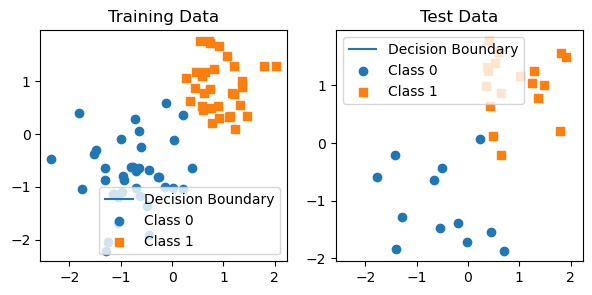

In [24]:
w, b = pso.weights, pso.bias.flatten() 

x0_min = -2
if w[1, 0] != 0:  # Check to avoid division by zero
    x1_min = (-(w[0, 0] * x0_min) - b) / w[1, 0]
else:
    x1_min = np.nan  # Handle division by zero case

x0_max = 2
if w[1, 0] != 0:  # Check to avoid division by zero
    x1_max = (-(w[0, 0] * x0_max) - b) / w[1, 0]
else:
    x1_max = np.nan
    
# Create subplots for train and test data
fig, ax = plt.subplots(1, 2, sharex=True, figsize=(7, 3))

# Plot decision boundary and training data
ax[0].plot([x0_min, x0_max], [x1_min, x1_max], label='Decision Boundary')
ax[0].scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], label='Class 0', marker='o')
ax[0].scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], label='Class 1', marker='s')
ax[0].set_title('Training Data')
ax[0].legend()

# Plot decision boundary and test data
ax[1].plot([x0_min, x0_max], [x1_min, x1_max], label='Decision Boundary')
ax[1].scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], label='Class 0', marker='o')
ax[1].scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], label='Class 1', marker='s')
ax[1].set_title('Test Data')
ax[1].legend(loc='upper left')

# Display the graph
plt.show()